# Unsupervised Learning for Gene Expression Analysis
 
 ## Overview
 
 This notebook analyzes gene expression data from the Spellman dataset to identify genes with similar expression patterns throughout the cell cycle using unsupervised learning techniques. I employ two main approaches:


1. **Feature Engineering + UMAP + GMM**: Extract meaningful features from time series data, reduce dimensionality with UMAP, and cluster with Gaussian Mixture Models
2. **Autoencoder + K-means**: Use deep learning for dimensionality reduction followed by K-means clustering
 
 

---

## 1. Import Libraries and Setup

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy import signal,stats
from scipy.signal import find_peaks
import umap
import warnings


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')


 ## 2. Data Loading and Initial Exploration
 
 I load the Spellman dataset which contains gene expression measurements across time points during the yeast cell cycle. The data is organized with:
 - Rows: Individual genes (identified by systematic names)
 - Columns: Time points (0, 20, 40, ..., 460 minutes)
 - Values: Log-ratio expression levels

In [3]:
import kagglehub

# Download and load the dataset
path = kagglehub.dataset_download("samira1992/gene-expression-bioinformatics-dataset")
df = pd.read_csv(os.path.join(path, "Spellman.csv"))

# Set gene IDs as index and convert column names to integers (time points)
df = df.set_index('time')
df.columns = [int(c) for c in df.columns]

print(f"Dataset dimensions: {df.shape}")
print(f"Time points: {list(df.columns)}")
print(f"Total genes: {len(df)}")
print(f"Time range: {df.columns.min()} to {df.columns.max()} minutes")

# Create a copy for clustering analysis
data = df.copy()
df_for_clustering = df.copy()

Dataset dimensions: (4381, 23)
Time points: [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260]
Total genes: 4381
Time range: 40 to 260 minutes



 ## 3. Exploratory Data Analysis (EDA)
 
 Before applying clustering algorithms, we need to understand the characteristics of our gene expression data:
 
 - **Distribution of expression values**: Are they normally distributed?
 - **Missing values**: Do we have complete time series for all genes?
 - **Overall trends**: Are there systematic changes across time?
 - **Gene expression patterns**: What do typical expression profiles look like? ## 3. Exploratory Data Analysis (EDA)

Dataset Statistics:
Shape: (4381, 23)
Missing values: 0

Summary statistics:
               40           50           60           70           80   \
count  4381.000000  4381.000000  4381.000000  4381.000000  4381.000000   
mean      0.007301    -0.007348     0.003192     0.013732    -0.010367   
std       0.466731     0.478514     0.361053     0.399159     0.424641   
min      -3.295000    -3.960000    -2.440000    -3.730000    -2.450000   
25%      -0.210000    -0.230000    -0.175000    -0.180000    -0.250000   
50%       0.035000     0.020000     0.030000     0.030000     0.010000   
75%       0.270000     0.260000     0.220000     0.230000     0.250000   
max       1.930000     2.060000     1.805000     1.770000     1.880000   

               90           100          110          120          130  ...  \
count  4381.000000  4381.000000  4381.000000  4381.000000  4381.000000  ...   
mean     -0.030854     0.027231     0.013716    -0.078443     0.056136  ...   
std       0.425090 

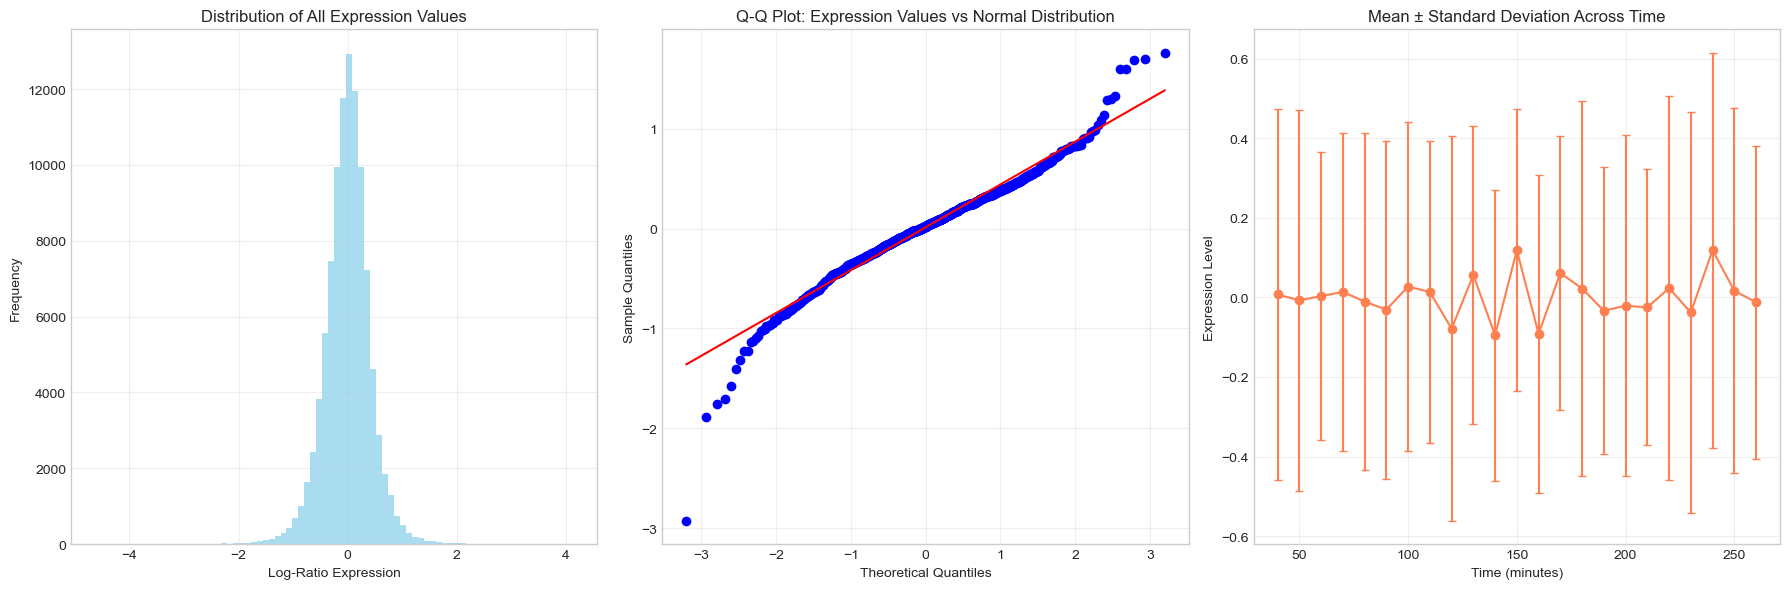

Shapiro-Wilk Test for Normality:
  Statistic: 0.9696
  P-value: 2.77e-31
  Interpretation: Data significantly deviates from normal distribution

Jarque-Bera Test for Normality:
  Statistic: 64227.0287
  P-value: 0.00e+00
  Interpretation: Data significantly deviates from normal distribution


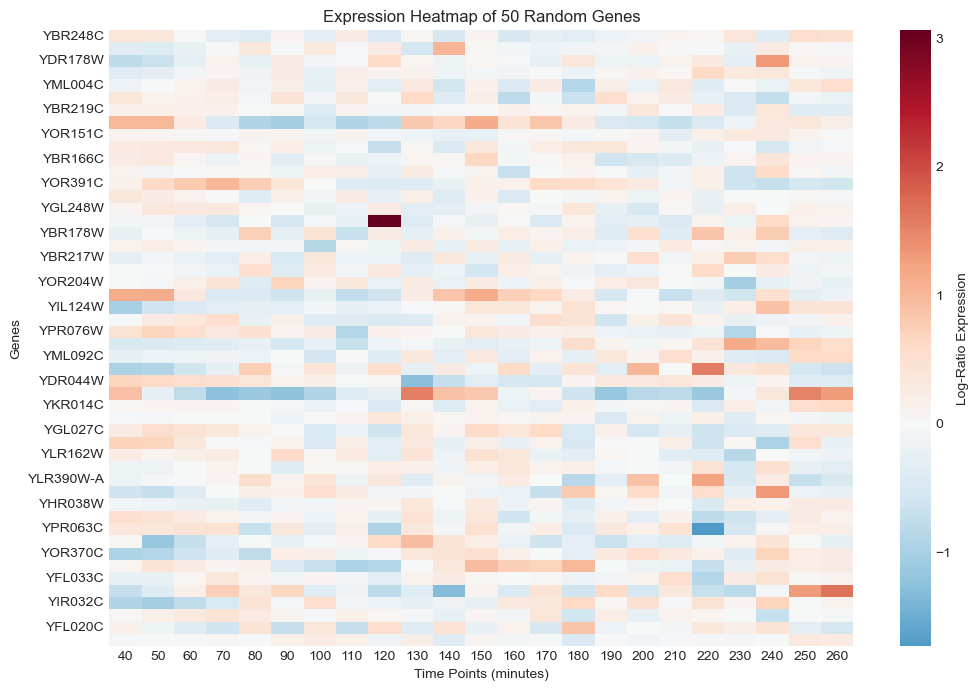

In [5]:
print("Dataset Statistics:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print("\nSummary statistics:")
print(df.describe())

# Distribution of all expression values and Q-Q plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
df.stack().hist(bins=80, alpha=0.7, color='skyblue')
plt.title("Distribution of All Expression Values")
plt.xlabel("Log-Ratio Expression")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)

# Q-Q plot to check normality
plt.subplot(1, 3, 2)
from scipy import stats
import scipy.stats as stats
# Sample data for Q-Q plot (all values would be too dense)
sample_data = df.stack().sample(n=1000, random_state=42)
stats.probplot(sample_data, dist="norm", plot=plt)
plt.title("Q-Q Plot: Expression Values vs Normal Distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True, alpha=0.3)

# Mean expression with standard deviation across time
plt.subplot(1, 3, 3)
means = df.mean(axis=0)  # Mean across genes for each time point
stds = df.std(axis=0)    # Standard deviation across genes for each time point
plt.errorbar(df.columns, means, yerr=stds, fmt='-o', capsize=3, color='coral')
plt.title("Mean ± Standard Deviation Across Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Expression Level")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistical test for normality
from scipy.stats import shapiro, jarque_bera
sample_for_test = df.stack().sample(n=5000, random_state=42)  # Shapiro-Wilk works better with smaller samples

# Shapiro-Wilk test (good for smaller samples)
shapiro_stat, shapiro_p = shapiro(sample_for_test)
print(f"Shapiro-Wilk Test for Normality:")
print(f"  Statistic: {shapiro_stat:.4f}")
print(f"  P-value: {shapiro_p:.2e}")
print(f"  Interpretation: {'Data appears normally distributed' if shapiro_p > 0.05 else 'Data significantly deviates from normal distribution'}")

# Jarque-Bera test (good for larger samples)
jb_stat, jb_p = jarque_bera(df.stack().dropna())
print(f"\nJarque-Bera Test for Normality:")
print(f"  Statistic: {jb_stat:.4f}")
print(f"  P-value: {jb_p:.2e}")
print(f"  Interpretation: {'Data appears normally distributed' if jb_p > 0.05 else 'Data significantly deviates from normal distribution'}")

# Expression heatmap of random genes
plt.figure(figsize=(12, 8))
random_genes = df.sample(50, random_state=42)
sns.heatmap(random_genes, cmap="RdBu_r", center=0, 
           cbar_kws={"label": "Log-Ratio Expression"})
plt.title("Expression Heatmap of 50 Random Genes")
plt.xlabel("Time Points (minutes)")
plt.ylabel("Genes")
plt.show()

 ## 4. Feature Engineering for Time Series Analysis
 
 Since I'm dealing with time series data, we need to extract meaningful features that capture different aspects of gene expression patterns:
 
 ### Feature Categories:
 
 1. **Basic Statistics**: Mean, standard deviation, amplitude (max-min)
 2. **Periodicity Features**: Measure how periodic/cyclic the expression is
 3. **Peak Analysis**: Number of peaks, peak widths, timing of first peak
 4. **Phase Analysis**: Dominant phase in frequency domain
 5. **Correlation Features**: Similarity to known cell cycle patterns
 6. **Autocorrelation**: Self-similarity at different time lags
 
 These features will help distinguish between:
 - **Periodic genes**: Show regular oscillations during cell cycle
 - **Constitutive genes**: Maintain relatively constant expression levels

In [7]:
def periodicity_score(expression):
    """
    Calculate periodicity score using Fourier analysis.
    Higher scores indicate more periodic/cyclic behavior.
    
    Returns the ratio of maximum power to average power in frequency domain.
    """
    # Remove linear trend from the time series
    detrended = signal.detrend(expression)
    # Perform Fourier transform
    fft = np.fft.fft(detrended)
    # Calculate power spectrum (energy at each frequency)
    power = np.abs(fft)**2
    # Ignore DC component (constant term) and focus on positive frequencies
    power_no_dc = power[1:len(power)//2]
    # Return ratio of max power to average power (measure of periodicity)
    return np.max(power_no_dc) / (np.mean(power_no_dc) + 1e-10)

def get_peak_properties(expression):
    """
    Analyze peaks in the expression time series.
    
    Returns:
    - Number of peaks
    - Average peak width
    - Time of first peak
    """
    # Find peaks with minimum prominence of 0.5
    peaks, _ = find_peaks(expression, prominence=0.5)
    
    if len(peaks) == 0:
        return 0, 0, 0
    
    n_peaks = len(peaks)
    
    # Calculate peak widths
    widths = signal.peak_widths(expression, peaks)[0]
    avg_width = np.mean(widths) if len(widths) > 0 else 0
    
    # Time of first peak
    first_peak_time = expression.index[peaks[0]]
    
    return n_peaks, avg_width, first_peak_time

def dominant_phase(expression):
    """
    Find the dominant phase in the frequency domain.
    This helps identify when in the cell cycle a gene is most active.
    """
    detrended = signal.detrend(expression)
    fft = np.fft.fft(detrended)
    freqs = np.fft.fftfreq(len(expression), d=1)  # Sampling interval = 1 (20 minutes)
    power = np.abs(fft)**2
    power[0] = 0  # Ignore DC component
    
    # Find frequency with maximum power
    idx = np.argmax(power[:len(power)//2])
    # Get phase at that frequency
    phase = np.angle(fft[idx])
    return phase

def max_autocorr(expression):
    """
    Calculate maximum autocorrelation for positive lags.
    High autocorrelation indicates self-similarity/periodicity.
    """
    # Center the data
    centered = expression - np.mean(expression)
    # Calculate autocorrelation
    acorr = np.correlate(centered, centered, mode='full')
    # Focus on positive lags only
    acorr = acorr[len(acorr)//2+1:]
    return np.max(acorr)

# Create prototype patterns for cell cycle phases
time_points = df.columns
n_points = len(time_points)

# G1 phase: Gaussian curve shifted left (early in cycle)
g1_prototype = np.roll(signal.windows.gaussian(M=n_points, std=n_points/10, sym=False), -n_points//4)

# G2/M phase: Gaussian curve shifted right (late in cycle)
g2m_prototype = np.roll(signal.windows.gaussian(M=n_points, std=n_points/10), n_points//2)

def get_correlation_features(expression):
    """
    Calculate correlation with G1 and G2/M phase prototypes.
    This helps classify genes based on their cell cycle timing.
    """
    # Center the expression data
    centered_expr = expression - np.mean(expression)
    
    # Correlate with G1 prototype
    corr_g1 = np.correlate(centered_expr, g1_prototype, mode='full')
    max_corr_g1 = np.max(np.abs(corr_g1))
    
    # Correlate with G2/M prototype
    corr_g2m = np.correlate(centered_expr, g2m_prototype, mode='full')
    max_corr_g2m = np.max(np.abs(corr_g2m))
    
    return pd.Series([max_corr_g1, max_corr_g2m], index=['corr_g1', 'corr_g2m'])


# Feature Extraction
 
 Now we'll extract all features for each gene. This creates a feature matrix where each row represents a gene and each column represents a different characteristic of its expression pattern.

 Create comprehensive feature dataframe

In [9]:

features = pd.DataFrame(index=df.index)

# Basic statistical features
features['mean'] = df.mean(axis=1)                    # Average expression level
features['std'] = df.std(axis=1)                      # Expression variability
features['amplitude'] = df.max(axis=1) - df.min(axis=1)  # Expression range

# Time series specific features
features['periodicity'] = df.apply(periodicity_score, axis=1)
features['max_autocorr'] = df.apply(max_autocorr, axis=1)
features['dominant_phase'] = df.apply(dominant_phase, axis=1)

# Peak analysis features
peak_props = df.apply(lambda row: get_peak_properties(row), axis=1, result_type='expand')
peak_props.columns = ['n_peaks', 'avg_peak_width', 'first_peak_time']
features = pd.concat([features, peak_props], axis=1)

# Cell cycle phase correlation features
correlation_features = df.apply(get_correlation_features, axis=1)
features = pd.concat([features, correlation_features], axis=1)

print(f"Feature matrix shape: {features.shape}")
print(f"Features extracted: {list(features.columns)}")

# Display feature statistics
print("\nFeature Statistics:")
print(features.describe())

Feature matrix shape: (4381, 11)
Features extracted: ['mean', 'std', 'amplitude', 'periodicity', 'max_autocorr', 'dominant_phase', 'n_peaks', 'avg_peak_width', 'first_peak_time', 'corr_g1', 'corr_g2m']

Feature Statistics:
              mean          std    amplitude  periodicity  max_autocorr  \
count  4381.000000  4381.000000  4381.000000  4381.000000   4381.000000   
mean      0.001687     0.397405     1.549192     3.435906      1.801321   
std       0.034966     0.170919     0.656713     1.400101      3.047429   
min      -0.256522     0.110273     0.400000     1.322275      0.052564   
25%      -0.017609     0.284722     1.110000     2.464148      0.523071   
50%       0.001957     0.360541     1.410000     3.049265      0.979571   
75%       0.021957     0.462898     1.800000     3.982360      1.878891   
max       0.183913     1.704793     6.060000     9.455231     48.010127   

       dominant_phase      n_peaks  avg_peak_width  first_peak_time  \
count     4381.000000  4381.00

# 5. Approach 1: UMAP Dimensionality Reduction + GMM Clustering
 
 ### Method Overview:
 
 1. **Standardization**: Scale features to have zero mean and unit variance
 2. **UMAP Reduction**: Reduce high-dimensional feature space to 2D for visualization and clustering
 3. **GMM Clustering**: Apply Gaussian Mixture Models to identify gene clusters
 4. **Evaluation**: Use silhouette score to assess clustering quality
 
 ### Why UMAP?
 - Preserves both local and global structure of the data
 - Better for clustering than linear methods like PCA
 - Good performance on biological data
 
 ### Why GMM?
 - Can model clusters with different shapes and sizes
 - Provides probabilistic cluster assignments
 - More flexible than K-means 

In [10]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
print(f"Features standardized. Shape: {scaled_features.shape}")

# UMAP dimensionality reduction
umap_reducer = umap.UMAP(
    n_neighbors=30,      # Balance between local and global structure
    min_dist=0.0,        # Allow points to be packed tightly
    n_components=2,      # 2D for visualization
    random_state=42      # Reproducibility
)
umap_data = umap_reducer.fit_transform(scaled_features)
print(f"UMAP completed. Reduced to shape: {umap_data.shape}")

# Apply GMM clustering
n_clusters = 2  # Based on biological expectation: periodic vs constitutive
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
labels = gmm.fit_predict(umap_data)

# Evaluate clustering quality
silhouette_avg = silhouette_score(umap_data, labels)
print(f"Silhouette Score with k={n_clusters}: {silhouette_avg:.4f}")

# Create results dataframe
final_results_V1 = pd.DataFrame({
    'Gene_ID': features.index,
    'Cluster': labels
})

# Analyze cluster composition
cluster_counts = pd.Series(labels).value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} genes ({count/len(labels)*100:.1f}%)")

Features standardized. Shape: (4381, 11)
Performing UMAP dimensionality reduction...
UMAP completed. Reduced to shape: (4381, 2)
Applying Gaussian Mixture Model clustering...
Silhouette Score with k=2: 0.7928

Cluster sizes:
Cluster 0: 4219 genes (96.3%)
Cluster 1: 162 genes (3.7%)


### Visualization and Analysis of UMAP + GMM Results

In [11]:
# Visualize UMAP clustering results with highlighted known genes
genes_to_label = {
    'ACT1': 'YFL039C',     # Actin - constitutive gene
    'CDC4': 'YFL009W',     # Cell division control protein
    'CDC28': 'YBR160W',    # Cell division control protein  
    'YAL046C': 'YAL046C'   # Another gene of interest
}

import plotly.express as px

# Prepare data for visualization
df_umap = pd.DataFrame(umap_data, columns=['UMAP1', 'UMAP2'], index=features.index)
df_umap['Cluster'] = labels.astype(str)

# Add labels for highlighted genes
df_umap['Gene_Label'] = ''
for display_name, gene_id in genes_to_label.items():
    if gene_id in df_umap.index:
        df_umap.at[gene_id, 'Gene_Label'] = display_name

# Create interactive scatter plot
fig = px.scatter(
    df_umap, x='UMAP1', y='UMAP2', color='Cluster',
    hover_name=df_umap.index,
    opacity=0.7,
    title=f'UMAP + GMM Clustering (k={n_clusters}) - Gene Expression Patterns',
    color_discrete_sequence=['#1f77b4', '#ff7f0e']  # Blue and orange
)

# Highlight specific genes
highlight_df = df_umap[df_umap['Gene_Label'] != '']
if not highlight_df.empty:
    fig.add_scatter(
        x=highlight_df['UMAP1'],
        y=highlight_df['UMAP2'],
        mode='markers+text',
        marker=dict(color='red', size=12, line=dict(width=2, color='black')),
        text=highlight_df['Gene_Label'],
        textposition='top right',
        name='Known Cell Cycle Genes',
        hovertext=highlight_df.index,
        showlegend=True
    )

fig.update_layout(
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2',
    width=900,
    height=700
)
fig.show()

## Feature Analysis by Cluster
 
 Let's examine how the different features we extracted vary between clusters. This will help us understand what biological characteristics distinguish the clusters.


In [13]:
# Add cluster labels to features for analysis
features_labeled = features.copy()
features_labeled['cluster'] = labels


# Print cluster statistics
print("Feature Statistics by Cluster:")
print("=" * 40)
for cluster_id in sorted(features_labeled['cluster'].unique()):
    cluster_data = features_labeled[features_labeled['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_data)} genes):")
    print(f"  Mean Periodicity: {cluster_data['periodicity'].mean():.3f}")
    print(f"  Mean Amplitude: {cluster_data['amplitude'].mean():.3f}")
    print(f"  Mean Number of Peaks: {cluster_data['n_peaks'].mean():.2f}")
    print(f"  Mean Autocorrelation: {cluster_data['max_autocorr'].mean():.0f}")


Feature Statistics by Cluster:

Cluster 0 (4219 genes):
  Mean Periodicity: 3.442
  Mean Amplitude: 1.574
  Mean Number of Peaks: 3.03
  Mean Autocorrelation: 2

Cluster 1 (162 genes):
  Mean Periodicity: 3.267
  Mean Amplitude: 0.911
  Mean Number of Peaks: 0.00
  Mean Autocorrelation: 1


 ### Gene Lists by Cluster
 
 Let's examine which genes fall into each cluster and identify some examples.


In [ ]:


# Generate final results and gene lists
gmm_best = GaussianMixture(n_components=2, random_state=42)
labels_best = gmm_best.fit_predict(umap_data)

final_results = pd.DataFrame({
    'Gene_ID': features.index,
    'Cluster': labels_best
})

# Separate genes by cluster
cluster_0_genes = final_results[final_results['Cluster'] == 0]['Gene_ID'].tolist()
cluster_1_genes = final_results[final_results['Cluster'] == 1]['Gene_ID'].tolist()

# Display first 10 genes from each cluster
print("Gene Classification Results:")
print("=" * 35)
print(f"\nCluster 0 - First 10 genes (likely constitutive):")
print(cluster_0_genes[:10])

print(f"\nCluster 1 - First 10 genes (likely periodic):")
print(cluster_1_genes[:10])



Gene Classification Results:

Cluster 0 - First 10 genes (likely constitutive):
['YAL001C', 'YAL014C', 'YAL016W', 'YAL020C', 'YAL022C', 'YAL036C', 'YAL038W', 'YAL039C', 'YAL040C', 'YAL044C']

Cluster 1 - First 10 genes (likely periodic):
['YAL046C', 'YAL065C', 'YBL066C', 'YBL077W', 'YBR173C', 'YBR181C', 'YBR206W', 'YBR264C', 'YCL017C', 'YCL056C']
